In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Set up TPU

In [2]:
import tensorflow as tf
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.MirroredStrategy()
#     strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


REPLICAS:  2


# GAN model 
using the example in
https://www.tensorflow.org/tutorials/generative/dcgan#what_are_gans

In [3]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display


# def generateImageGrids(images, grid_shape, grid_count):
#     grid_h, grid_w = grid_shape
#     import random
#     random_images = random.sample(images, grid_count * grid_h * grid_w)
#     grid_images = \
#         [
#             np.vstack([
#                 np.hstack([images_in_grid[j*grid_h + i] 
#                            for i in range(0, grid_w)
#                           ])
#                 for j in range(0, grid_h)
#             ])
#             for images_in_grid in np.array_split(random_images, grid_count)
#         ]
#     return grid_images

# def rescale(images, scale_factors):
#     scale_factors = np.array(scale_factors)
#     images = np.array(images)
    
#     pil_images = [PIL.Image.fromarray(image) for image in images]
# #     print(pil_images[0].thumbnail((256, 256)))
#     [image.thumbnail((image.size / scale_factors).astype(int)) for image in pil_images]
#     scaled_images = [np.array(image).astype(int) for image in pil_images]
#     return np.array(scaled_images)

    
# def fuseImages(images, ret_count):
# #     f, axarr = plt.subplots(ret_count,4)
# #     f.set_size_inches(10,10)
# #     os.mkdir('fused_monet')

#     blended_images =[]
#     import random
#     # Randomly sample non-repeating pairs
#     all_pairs = [(x, y) for x in range(len(images)) for y in range(0, x)]
#     random_pairs = random.sample(all_pairs, ret_count)
#     for i in range(ret_count):
#         display.clear_output(wait=True)
#         print(str(i), "/", ret_count)
#         img1 = PIL.Image.fromarray(images[random_pairs[i][0]].numpy())
#         img2 = PIL.Image.fromarray(images[random_pairs[i][1]].numpy())
#         blended_image = PIL.Image.blend(img1, img2, 0.5)
# #         axarr[i][0].imshow(blended_image)
#         #  An enhancement factor of 0.0 gives a solid grey image. A factor of 1.0 gives the original image.
#         blended_image = PIL.ImageEnhance.Contrast(blended_image).enhance(2)
#         blended_image.save('fused_monet/fused_{:04d}_{:04d}.jpg'.format(random_pairs[i][0], random_pairs[i][1]))
# #         blended_images.append(np.array(blended_image))
        
# #         axarr[i][1].imshow(blended_image)
# #         axarr[i][2].imshow(img1)
# #         axarr[i][3].imshow(img2)
# #     plt.show()    

#     return np.array(blended_images)

# Load training JPG images

In [5]:
TRAINING_JPG_DIR = '/kaggle/input/gan-getting-started/monet_jpg'
TRAINING_JPG_PATHS = tf.io.gfile.glob(TRAINING_JPG_DIR + '/*.jpg')
TRAINING_FUSED_DIR = '/kaggle/input/monet-fused/fused_monet'
TRAINING_FUSED_PATHS = tf.io.gfile.glob(TRAINING_FUSED_DIR + '/*.jpg')

fused_image_count = 2000
TRAINING_PATHS = TRAINING_JPG_PATHS + TRAINING_FUSED_PATHS[:fused_image_count]
print("image count:", len(TRAINING_PATHS))
# Define a function to generate image paths
def image_generator():
    for image_path in TRAINING_PATHS:
        yield image_path

# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_generator(
    image_generator,
    output_signature=tf.TensorSpec(shape=(), dtype=tf.string)
)

def load_and_preprocess_image(image_path):
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image to a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the pixel values to floats in the range [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Normalize the images to [-1, 1]
    image = (image - 127.5) / 127.5  
    return image

# Load and preprocess the images
train_dataset = train_dataset.map(load_and_preprocess_image)

# Shuffle and batch the dataset as needed
BUFFER_SIZE = 500
BATCH_SIZE = 100
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

image count: 2300


Dataset size: -2
Dataset Element Spec: TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None)


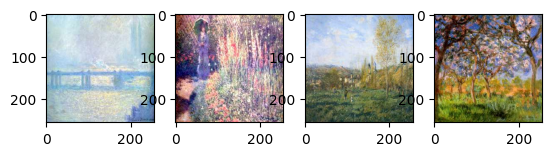

In [6]:
print("Dataset size:", tf.data.experimental.cardinality(train_dataset).numpy())
print("Dataset Element Spec:", train_dataset.element_spec)
first_batch = next(iter(train_dataset))
_, img_h, img_w, img_ch = first_batch.shape

f, axarr = plt.subplots(1,4) 
axarr[0].imshow(first_batch[0] * 127.5 + 127.5)
axarr[1].imshow(first_batch[1] * 127.5 + 127.5)
axarr[2].imshow(first_batch[2] * 127.5 + 127.5)
axarr[3].imshow(first_batch[3] * 127.5 + 127.5)
plt.show()

# Define model functions

In [7]:
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def add_deconv_block(model, num_filters, kernel_size, kernel_initializer, strides):
    transConv = layers.Conv2DTranspose(
                                    filters = num_filters, 
                                    kernel_size = kernel_size,
                                    kernel_initializer = kernel_initializer,
                                    strides = strides, 
                                    padding = 'same', 
                                    use_bias = False)
    model.add(transConv)    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))  

def add_conv_block(model, num_filters, kernel_size, kernel_initializer, strides, activation=True):
    conv = layers.Conv2D(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding='same',
        strides=strides,
    )
    
    model.add(conv)
    
    if activation:
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.SpatialDropout2D(0.3))    
        
'''
a_trans_conv_layer_count - values in the range [0, log_2(min(a_out_h, a_out_w))]
a_last_trans_conv_layer_size - bigger or equal to a_out_ch_count
'''        
def make_generator_model(a_in_noise_dim, a_out_h, a_out_w, a_out_ch_count, 
                            a_trans_conv_layer_count, a_last_trans_conv_layer_size):
    # decreasing integers of power of 2
    f = np.array([2**i for i in range(a_trans_conv_layer_count + 1)][::-1])
    # number of filters on each conv trans layer
    trans_conv_layer_sizes = f * a_last_trans_conv_layer_size
    # image tensor height, width and channel count of the first conv trans layer input
    in_h = a_out_h // f[0]
    in_w = a_out_w // f[0]
    in_ch_count = trans_conv_layer_sizes[0]
    
    # setup model and first layer
    model = tf.keras.Sequential(name="generator")
    model.add(layers.Input(shape=(a_in_noise_dim,), name="generator_noise_input"))
    model.add(layers.Dense(in_h * in_w * in_ch_count, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((in_h, in_w, in_ch_count)))
    # Think of those as in_h x in_w images with in_ch_count channels
    assert model.output_shape == (None, in_h, in_w, in_ch_count)  # Note: None is the batch size
    # from now on we increase image size two times and reduce channel count two times
    # on each new layer
    for i in range(1, a_trans_conv_layer_count + 1):
        add_deconv_block(model, trans_conv_layer_sizes[i], 5, w_init, 2)

    # decrease channel count if necessary
    if a_last_trans_conv_layer_size > a_out_ch_count:
        add_conv_block(model, a_out_ch_count, 5, w_init, 1, False)
    activation = layers.Activation("tanh")
    model.add(activation)
    assert model.output_shape == (None, a_out_h, a_out_w, a_out_ch_count)
    
    return model

'''
a_conv_layer_count - values in the range [0, log_2(min(a_in_h, a_in_w))]
''' 
def make_discriminator_model(a_in_h, a_in_w, a_in_ch_count, a_conv_layer_count, a_first_conv_layer_size):
    # increasing integers of power of 2
    f = np.array([2**i for i in range(a_conv_layer_count)])
    conv_layer_sizes = f * a_first_conv_layer_size
    
    # start the model
    model = tf.keras.Sequential()    
    model.add(layers.Input(shape=(a_in_h, a_in_w, a_in_ch_count), name="discriminator_image_input"))
    
    # from now on we decrease image size two times and increase channel count two times
    # on each new layer
    for i in range(a_conv_layer_count):
        add_conv_block(model, conv_layer_sizes[i], 5, w_init, 2, True)        
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
#     model.add(layers.Dense(1 , activation='sigmoid'))

    return model

# The Generator

In [8]:
noise_dim = 100

with strategy.scope():
    generator = make_generator_model(noise_dim, img_h, img_w, img_ch, 5, 16)
generator.summary()
noise = tf.random.normal([1, noise_dim])
# print(noise)
generated_image = generator(noise, training=False)
# print(generated_image[0])
# print(generated_image[0] * 127.5 + 127.5)
# plt.imshow(np.array(generated_image[0, :, :, :] * 127.5 + 127.5).astype(int))

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3276800   
                                                                 
 batch_normalization (BatchN  (None, 32768)            131072    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      3276800   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 256)      10

# The Discriminator

In [13]:
# Use the (as yet untrained) discriminator to classify the generated images as real or fake. 
# The model will be trained to output positive values for real images, and negative values for fake images.

with strategy.scope():
    discriminator = make_discriminator_model(img_h, img_w, img_ch, 6, 16)
decision = discriminator(generated_image)
print(decision)
discriminator.summary()

tf.Tensor([[6.005067e-07]], shape=(1, 1), dtype=float32)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 128, 128, 16)      1216      
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 128, 128, 16)      0         
                                                                 
 spatial_dropout2d_22 (Spati  (None, 128, 128, 16)     0         
 alDropout2D)                                                    
                                                                 
 conv2d_24 (Conv2D)          (None, 64, 64, 32)        12832     
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 64, 64, 32)        0         
                                                                 
 spatial_dropout2d_23 (Spati  (None, 64, 64, 32)       0       

# Define the loss and optimizers

In [14]:
with strategy.scope():

    # This method returns a helper function to compute cross entropy loss
#     cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
#     def wasserstein_loss(y_true, y_pred):
#         from keras import backend
#         return backend.mean(y_true * y_pred)
#     cross_entropy = wasserstein_loss

    # This method quantifies how well the discriminator is able to distinguish real images from fakes. 
    # It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's 
    # predictions on fake (generated) images to an array of 0s.
    def discriminator_loss(real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        return tf.reduce_mean(real_loss), tf.reduce_mean(fake_loss)

    # The generator's loss quantifies how well it was able to trick the discriminator. 
    # Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). 
    # Here, compare the discriminators decisions on the generated images to an array of 1s.
    def generator_loss(fake_output):
        losses = cross_entropy(tf.ones_like(fake_output), fake_output)
        return tf.reduce_mean(losses)

    # The discriminator and the generator optimizers are different since you will train two networks separately.
    generator_optimizer = tf.keras.optimizers.Adam(1e-2)
    discriminator_optimizer = tf.keras.optimizers.Adam(1 * 1e-4)
    # generator_optimizer = tf.keras.optimizers.Adam(1e-5)
    # discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


# Save checkpoints
    checkpoint_dir = './training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

# Define the training loop
The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [15]:
EPOCHS = 1000
checkpoint_save_freq = 10
test_grid_update_freq = 10
generated_image_grid_shape = (2, 3)
test_grid_input_count = np.prod(generated_image_grid_shape, dtype=int)
test_grid_seeds = tf.random.normal([test_grid_input_count, noise_dim])

gen_losses = []
disc_real_losses = []
disc_fake_losses = []
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
with strategy.scope():
    @tf.function
    def train_step(images):
        noise = tf.random.normal([BATCH_SIZE, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)

            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_real_loss, disc_fake_loss = discriminator_loss(real_output, fake_output)
#             gen_losses.append(float(gen_loss))
#             disc_real_losses.append(float(disc_real_loss))
#             disc_fake_losses.append(float(disc_fake_loss))
            disc_loss = disc_real_loss + disc_fake_loss

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        return float(gen_loss), float(disc_real_loss), float(disc_fake_loss)
    

def generate_images(model, seeds):
    predictions = model(seeds, training=False)
    images = np.array(predictions * 127.5 + 127.5).astype(int)
    return images

def save_image(image, prefix_int):
    fig = plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.jpg'.format(prefix_int))
    plt.close(fig)

def showEvaluationPlots(gen_losses, disc_real_losses, disc_fake_losses, images, window):
    import matplotlib.gridspec as gridspec

    fig = plt.figure(figsize=(10, 4), constrained_layout=True)
    subfigs = fig.subfigures(1, 2, width_ratios=[3, 5])
#     fig, ax = plt.subplots(4,1, gridspec_kw={'height_ratios': [2, 1, 1, 6]})
    sub1 = subfigs[0].subplots(3,1)
    sub2 = subfigs[1].subplots(images.shape[0], images.shape[1])
    sub1[0].plot(gen_losses[-window:], 'b', label='gen loss')
    sub1[0].plot(np.add(disc_real_losses[-window:], disc_fake_losses[-window:]), 'g', label='disc loss')
    sub1[0].legend(loc='upper left')
    sub1[1].plot(gen_losses[-window:], 'b', label='disc loss')
    sub1[1].set_label("gen")                   
    sub1[2].plot(disc_real_losses[-window:], 'g', label='disc real loss')
    sub1[2].plot(disc_fake_losses[-window:], 'r', label='disc fake loss')
    sub1[2].legend(loc='upper left')
    sub1[2].set_label("disc")            
    for x, y in np.ndindex(images.shape[0:2]):
        sub2[x,y].imshow(images[x,y])

    plt.show()

In [16]:

def train(dataset, epochs):
    
    gen_images = np.zeros((np.prod(generated_image_grid_shape, dtype=int),
                           img_h, img_w, img_ch))
    i = 0
    iteration = 0 
    with strategy.scope():

        for epoch in range(epochs):
            print("Epoch... ", epoch)
            start = time.time()
            for image_batch in dataset:
    #             print("new batch...")
#                 train_step(image_batch)
                results = strategy.run(train_step, args=(image_batch,))
                # iterate per replica returned values
                for gen_loss, disc_real_loss, disc_fake_loss in strategy.experimental_local_results(results):
                    gen_losses.append(float(gen_loss))
                    disc_real_losses.append(float(disc_real_loss))
                    disc_fake_losses.append(float(disc_fake_loss))
                    
                display.clear_output(wait=True)
                if i == test_grid_update_freq:
                    i = 0
                    gen_images = generate_images(generator, test_grid_seeds)
                    save_image(gen_images[0], iteration)
#                     f_gen = generate_and_save_images(generator, epoch + 1, seed)
                showEvaluationPlots(gen_losses, disc_real_losses, disc_fake_losses, 
                                    gen_images.reshape(generated_image_grid_shape + gen_images.shape[1:]), 150)
                i += 1
                    
                iteration += 1
                print("Epoch... ", epoch)
                print("Tot iter... ", iteration)

    #         Save the model every checkpoint_save_freq epochs
            if (epoch + 1) % checkpoint_save_freq == 0:
                checkpoint.save(file_prefix = checkpoint_prefix)

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
#         display.clear_output(wait=True)
#         generate_and_save_images(generator,epochs,seed)

# Train the model

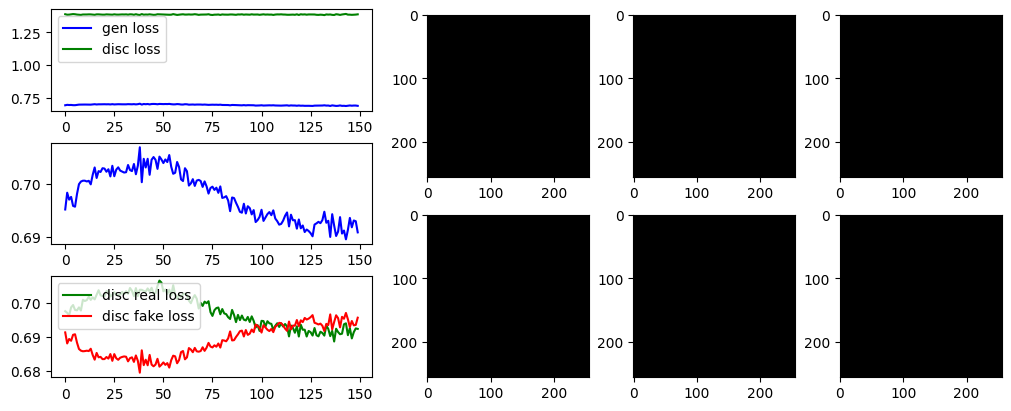

Epoch...  7
Tot iter...  184


In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint('/kaggle/input/monet-gan/training_checkpoints'))
# generator_optimizer = tf.keras.optimizers.Adam(1e-2        )
# discriminator_optimizer = tf.keras.optimizers.Adam(1 * 1e-4)
with strategy.scope():
    train(train_dataset, EPOCHS)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.jpg'.format(epoch_no))
display_image(EPOCHS)
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.jpg')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

from IPython.display import HTML
HTML('<img src="dcgan.gif">')

# import tensorflow_docs.vis.embed as embed
# embed.embed_file(anim_file)

In [ ]:
showEvaluationPlots(gen_losses, disc_real_losses, disc_fake_losses, np.zeros((2,3,256,256,3)), len(gen_losses))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

IMG_H=64
IMG_W=64
IMG_C=3
def deconv_block(inputs, num_filters, kernel_size, strides, bn=True):
    x = Conv2DTranspose(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding="same",
        strides=strides,
        use_bias=False
    )(inputs)
 
    if bn:
         x = BatchNormalization()(x)
         x = LeakyReLU(alpha=0.2)(x)
    return x

def conv_block(inputs, num_filters, kernel_size, padding="same", strides=2, activation=True):
    x = Conv2D(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding=padding,
        strides=strides,
    )(inputs)
    if activation:
         x = LeakyReLU(alpha=0.2)(x)
         x = Dropout(0.3)(x)
    return x

def build_generator(latent_dim):
    f = [2**i for i in range(5)][::-1]
    filters = 32
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides
    noise = tf.keras.Input(shape=(latent_dim,), name="generator_noise_input")
    x = Dense(f[0] * filters * h_output * w_output, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((h_output, w_output, 16 * filters))(x)
    for i in range(1, 5):
        x = deconv_block(x,
            num_filters=f[i] * filters,
            kernel_size=5,
            strides=2,
            bn=True
        )
    x = conv_block(x,
        num_filters=3,
        kernel_size=5,
        strides=1,
        activation=False
    )
    fake_output = Activation("tanh")(x)
    return Model(noise, fake_output, name="generator")

def build_discriminator():
    f = [2**i for i in range(4)]
    image_input = Input(shape=(IMG_H, IMG_W, IMG_C))
    x = image_input
    filters = 64
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides
    for i in range(0, 4):
        x = conv_block(x, num_filters=f[i] * filters, kernel_size=5, strides=2)
    x = Flatten()(x)
    x = Dense(1)(x)
    return Model(image_input, x, name="discriminator")

build_generator(128).summary()
build_discriminator().summary()